# Exercice 1 : Initialisation de l’environnement et des structures de données

- ***Objectif :*** Initialiser l'environnement `Taxi-v3` et créer les tables de politique et de valeur.

In [14]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Initialisation de l'environnement
env = gym.make("Taxi-v3", render_mode="human")

# Nombre d'états et d'actions
state_size = env.observation_space.n
action_size = env.action_space.n

# Création d'une table de politique avec des probabilités égales pour chaque action
policy_table = np.ones((state_size, action_size)) / action_size

# Création d'une table de valeurs initialisée à zéro
value_table = np.zeros(state_size)

# Affichage des premières lignes des tables
print("Policy Table Sample:\n", policy_table[:5])
print("Value Table Sample:\n", value_table[:5])

Policy Table Sample:
 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]
Value Table Sample:
 [0. 0. 0. 0. 0.]


# Exercice 2 : Exploration et collecte d’épisodes

- ***Objectif :*** Explorer l'environnement en exécutant des actions aléatoires et collecter des épisodes.

In [17]:
state, _ = env.reset()

for t in range(20):
    action = env.action_space.sample()  # Action aléatoire
    next_state, reward, done, _, _ = env.step(action)

    print(f"Step {t}: Action={action}, Reward={reward}, Next State={next_state}")

    if done:
        state, _ = env.reset()  # Réinitialiser l'environnement
env.close()

Step 0: Action=0, Reward=-1, Next State=263
Step 1: Action=3, Reward=-1, Next State=243
Step 2: Action=5, Reward=-10, Next State=243
Step 3: Action=5, Reward=-10, Next State=243
Step 4: Action=3, Reward=-1, Next State=223
Step 5: Action=2, Reward=-1, Next State=243
Step 6: Action=4, Reward=-10, Next State=243
Step 7: Action=4, Reward=-10, Next State=243
Step 8: Action=0, Reward=-1, Next State=343
Step 9: Action=3, Reward=-1, Next State=323
Step 10: Action=1, Reward=-1, Next State=223
Step 11: Action=4, Reward=-10, Next State=223
Step 12: Action=4, Reward=-10, Next State=223
Step 13: Action=5, Reward=-10, Next State=223
Step 14: Action=4, Reward=-10, Next State=223
Step 15: Action=2, Reward=-1, Next State=243
Step 16: Action=0, Reward=-1, Next State=343
Step 17: Action=3, Reward=-1, Next State=323
Step 18: Action=0, Reward=-1, Next State=423
Step 19: Action=5, Reward=-10, Next State=423


# Exercice 3 : Mise à jour de la politique avec PPO

- ***Objectif :*** Mettre à jour la politique en utilisant l'algorithme PPO (Proximal Policy Optimization).

In [5]:
# Hyperparameters
gamma = 0.99
lr_policy = 0.001  # Learning rate for policy
lr_value = 0.01    # Learning rate for value function
clip_epsilon = 0.2
num_episodes = 40000
epsilon_start = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
max_steps_per_episode = 200

# Initialization of structures
policy_table = np.ones((state_size, action_size)) / action_size  # Uniform initialization
value_table = np.zeros(state_size)  # Value table for advantage calculation
episode_rewards = []  # List to track rewards over episodes

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    episode_states = []
    episode_actions = []
    episode_rewards_ep = []
    episode_probs = []
    steps = 0
    
    # Collect episode
    while not done and steps < max_steps_per_episode:
        probs = policy_table[state]
        
        # Ensure probabilities are valid (non-negative and sum to 1)
        probs = np.clip(probs, 0, 1)  # Clip negative probabilities to 0
        probs = probs / np.sum(probs)  # Normalize the probabilities to sum to 1
        
        action = np.random.choice(action_size, p=probs)  # Random action based on policy
        
        next_state, reward, done, _, _ = env.step(action)
        
        # Store episode details for later updates
        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards_ep.append(reward)
        episode_probs.append(probs[action])
        
        state = next_state
        steps += 1
    
    # Calculate advantages
    discounted_rewards = np.zeros_like(episode_rewards_ep, dtype=np.float32)
    running_reward = 0
    for t in reversed(range(len(episode_rewards_ep))):
        running_reward = episode_rewards_ep[t] + gamma * running_reward
        discounted_rewards[t] = running_reward - value_table[episode_states[t]]
    
    # Normalize advantages
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)
    
    # PPO Update
    for state, action, old_prob, advantage in zip(episode_states, episode_actions, episode_probs, discounted_rewards):
        # Calculate ratio
        new_prob = policy_table[state, action]
        ratio = new_prob / (old_prob + 1e-8)
        
        # Clipping the ratio for stability
        clipped_ratio = np.clip(ratio, 1 - clip_epsilon, 1 + clip_epsilon)
        
        # Update policy using clipped objective
        policy_table[state, action] += lr_policy * min(ratio * advantage, clipped_ratio * advantage)
        
        # Normalize the probabilities to ensure they sum to 1
        policy_table[state] /= policy_table[state].sum()
        
        # Update value function
        value_table[state] += lr_value * (advantage + value_table[state] - value_table[state])
    
    # Decay epsilon for exploration-exploitation balance
    epsilon = max(epsilon_start * (epsilon_decay ** episode), epsilon_min)
    
    # Track the total reward for this episode
    episode_rewards.append(np.sum(episode_rewards_ep))
    
    # Log every 100 episodes to track progress
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        print(f"Épisode {episode + 1}/{num_episodes} - Récompense moyenne: {avg_reward:.2f}")

Épisode 100/40000 - Récompense moyenne: -758.26
Épisode 200/40000 - Récompense moyenne: -750.20
Épisode 300/40000 - Récompense moyenne: -775.85
Épisode 400/40000 - Récompense moyenne: -755.69
Épisode 500/40000 - Récompense moyenne: -766.32
Épisode 600/40000 - Récompense moyenne: -776.12
Épisode 700/40000 - Récompense moyenne: -760.59
Épisode 800/40000 - Récompense moyenne: -774.74
Épisode 900/40000 - Récompense moyenne: -759.55
Épisode 1000/40000 - Récompense moyenne: -763.82
Épisode 1100/40000 - Récompense moyenne: -767.47
Épisode 1200/40000 - Récompense moyenne: -755.75
Épisode 1300/40000 - Récompense moyenne: -759.55
Épisode 1400/40000 - Récompense moyenne: -745.72
Épisode 1500/40000 - Récompense moyenne: -745.17
Épisode 1600/40000 - Récompense moyenne: -743.14
Épisode 1700/40000 - Récompense moyenne: -734.67
Épisode 1800/40000 - Récompense moyenne: -739.11
Épisode 1900/40000 - Récompense moyenne: -751.07
Épisode 2000/40000 - Récompense moyenne: -744.60
Épisode 2100/40000 - Récompen

# Exercice 4 : Évaluation de l’agent après entraînement

- ***Objectif :*** Évaluer les performances de l'agent après l'entraînement.

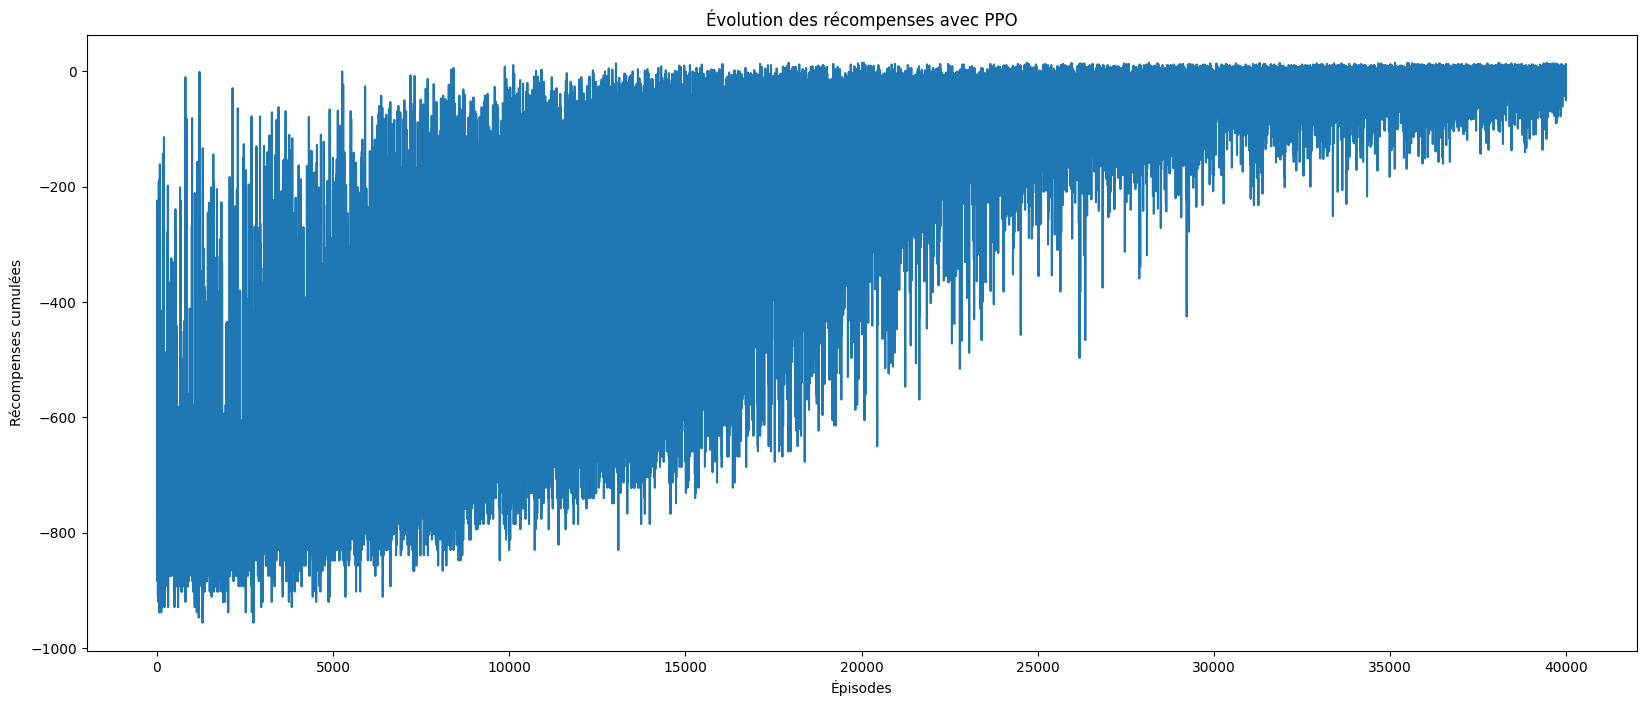

Évaluation Épisode 1/20 - Récompense: 6
Évaluation Épisode 2/20 - Récompense: 6
Évaluation Épisode 3/20 - Récompense: 5
Évaluation Épisode 4/20 - Récompense: 8
Évaluation Épisode 5/20 - Récompense: 9
Évaluation Épisode 6/20 - Récompense: 11
Évaluation Épisode 7/20 - Récompense: 11
Évaluation Épisode 8/20 - Récompense: 4
Évaluation Épisode 9/20 - Récompense: 11
Évaluation Épisode 10/20 - Récompense: 15
Évaluation Épisode 11/20 - Récompense: 10
Évaluation Épisode 12/20 - Récompense: 6
Évaluation Épisode 13/20 - Récompense: 8
Évaluation Épisode 14/20 - Récompense: 15
Évaluation Épisode 15/20 - Récompense: 6
Évaluation Épisode 16/20 - Récompense: 7
Évaluation Épisode 17/20 - Récompense: 8
Évaluation Épisode 18/20 - Récompense: 12
Évaluation Épisode 19/20 - Récompense: 6
Évaluation Épisode 20/20 - Récompense: 10

Récompense moyenne après entraînement: 8.7


In [6]:
# Affichage du graphique des performances
plt.figure(figsize=(20,8))
plt.plot(range(num_episodes), episode_rewards)
plt.xlabel("Épisodes")
plt.ylabel("Récompenses cumulées")
plt.title("Évolution des récompenses avec PPO")
plt.show()

# Évaluation finale
num_eval_episodes = 20
total_rewards = []
max_steps_per_episode = 100  # Limite de pas par épisode

for ep in range(num_eval_episodes):
    state, _ = env.reset()
    done = False
    episode_reward = 0
    steps = 0

    while not done and steps < max_steps_per_episode:
        action = np.argmax(policy_table[state])  # Action selon la politique
        next_state, reward, done, _, _ = env.step(action)
        episode_reward += reward
        state = next_state
        steps += 1

    total_rewards.append(episode_reward)

    print(f"Évaluation Épisode {ep + 1}/{num_eval_episodes} - Récompense: {episode_reward}")

# Affichage des performances
print(f"\nRécompense moyenne après entraînement: {np.mean(total_rewards)}")

### Conclusion

Après 40 000 épisodes d'entraînement, l'agent a montré une amélioration progressive de ses performances, avec une récompense moyenne passant de -758,26 au début à -10,83 à la fin. Lors de l'évaluation finale sur 20 épisodes, l'agent a obtenu une récompense moyenne de 8,7, ce qui indique que l'agent a appris à mieux naviguer dans l'environnement au fur et à mesure des épisodes. Ces résultats montrent une amélioration constante des performances, bien que les récompenses restent relativement faibles, suggérant que l'agent pourrait encore bénéficier de certains ajustements dans l'algorithme ou les hyperparamètres.
